In [1]:
import pathlib
import sys

root = pathlib.Path().cwd()
while not root.joinpath('.projectroot').exists():
    root = root.parent

sys.path.append(root.as_posix())

In [2]:
import os
import numpy as np
import pandas as pd
from ast import literal_eval
from collections import Counter, defaultdict
from functools import partial

import torch
from hw5.common import TaggerDataset, TorchTrainable

from tqdm import tqdm
from sklearn.metrics import classification_report

DATA = pathlib.Path('data')

__load data__

In [3]:
train_tokens = pd.read_csv(DATA / 'prepared_train.csv', converters={'tokens': literal_eval})
valid_tokens = pd.read_csv(DATA / 'prepared_valid.csv', converters={'tokens': literal_eval})

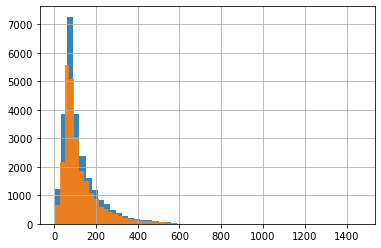

In [4]:
# распределение длин текстов
train_tokens['tokens'].str.len().hist(bins=50, alpha=0.9)
valid_tokens['tokens'].str.len().hist(bins=50, alpha=0.9);

In [5]:
class TokenDictionary:
    def __init__(self, corpus):
        all_tokens = [token for doc in corpus for token in doc]
        self.counter = Counter(all_tokens)
        self.id2token = dict(enumerate(set(all_tokens), 1))
        self.token2id = defaultdict(int, {v: k for k, v in self.id2token.items()})      # если токена нет в словаре, возвращать 0
        self.size = len(self.id2token)
    
    def convert(self, tokens, length):
        pad = [0] * (length - len(tokens))
        return [self.token2id[w] for w in tokens][-length:] + pad
        

# collect dictionary
words = TokenDictionary(train_tokens['tokens'])

In [9]:
# build data
LENGTH = 100
BATCH_SIZE = 256

train = train_tokens['tokens'].apply(partial(words.convert, length=LENGTH))
valid = valid_tokens['tokens'].apply(partial(words.convert, length=LENGTH))

train_dataset = TaggerDataset(train.values, train_tokens['is_positive'].apply(lambda x: [float(x)]).values)
valid_dataset = TaggerDataset(valid.values, valid_tokens['is_positive'].apply(lambda x: [float(x)]).values)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

__NN torch__

In [7]:
class Net(torch.nn.Module, TorchTrainable):
    def __init__(self, dict_size, embedding_dim=128, drop=0.3, num_classes=1):
        super().__init__()
        self.embedding = torch.nn.Embedding(dict_size, 2 * embedding_dim)
        self.conv_1 = torch.nn.Conv1d(2 * embedding_dim, embedding_dim, kernel_size=2)

        self.linear = torch.nn.Linear(embedding_dim, num_classes)
        self.dp = torch.nn.Dropout(drop)
        
    def forward(self, x):        
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv_1(x)

        x = torch.relu(x)
        x = torch.max_pool1d(x, 2)
        x = self.dp(x)

        x = torch.max(x, axis=2).values
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Selected device: {device}')

model = Net(dict_size=120000, embedding_dim=128, drop=0.05, num_classes=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

model.fit(train_loader, optimizer, criterion, epochs=3, device=device)

Selected device: cuda


Epoch 3/3: 100%|██████████| 98/98 [00:03<00:00, 30.03it/s, cumulative loss per item=0.000222]


Done.


In [11]:
model.eval()
predicts = (model.predict(valid_loader).flatten() > 0.5) * 1
print(classification_report(valid_tokens['is_positive'], predicts))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84     12500
           1       0.82      0.89      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [ ]:
#